In [2]:
import sys
sys.path.insert(0, '../../')  
import math
import numpy as np
import matplotlib.pyplot as plt 
from gasp import process_data_for_gasp, create_data_mask, train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_sampling, simulate_ssfp_simple, SSFPParams, responses, simulation, sampling

In [16]:
# Example T1/T2 ratios for different tissue types
[0.25/0.07, 0.5/0.04, 0.9/.05, 0.9/0.1, 0.6/0.08, 4/2]

[3.571428571428571, 12.5, 18.0, 9.0, 7.5, 2.0]

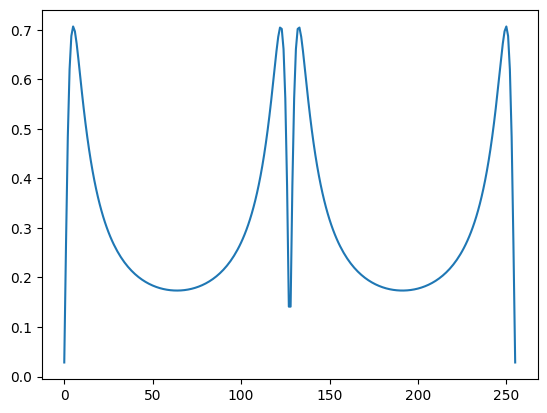

In [32]:
alpha = np.deg2rad(20)
N = 128
rMin = 0.5
rMax = 20
T1T2ratio = np.linspace(rMin, rMax, N)
n_points = 16
TRs = [5e-3, 10e-3, 20e-3]

TRs, PCs = sampling.grid_TR_sampling(n_points=n_points, TRs=TRs)
params = SSFPParams(n_points, alpha, TRs, PCs)
M = simulate_ssfp_simple(T1=1*T1T2ratio[0], T2 =1, params=params)
plt.plot(np.abs(M[0,:,0]))
plt.show()

In [ ]:
def SensitivityAnalysis(D, alpha0 = 10, alpha1 = 90, Nx = 90):
    width = 256
    height = 1
    npcs = 16
    TRs = [5e-3, 10e-3, 20e-3]
    n_points = npcs * len(TRs)
    gradient = 2 * np.pi
    phantom_type = 'line'
    method = 'affine'
    Na = npcs * len(TRs) + 1
    Alpha = np.linspace(alpha0, alpha1, Nx)
    Alpha = np.deg2rad(Alpha)
    TRs, PCs = sampling.grid_TR_sampling(n_points=n_points, TRs=TRs)

    # Train
    A = np.zeros((Nx, Na), dtype=np.complex128)
    for i, alpha in enumerate(Alpha):
        params = SSFPParams(n_points, alpha, TRs, PCs)
        M = simulate_ssfp_sampling(width=width, height=height, params=params, 
                                   minTR = np.min(params.TRs), gradient = gradient, phantom_type=phantom_type)
        Ic, An = train_gasp(M, D, method=method)
        A[i, :] = np.array(An)

    # Evaluate
    MSE_2D = np.zeros((Nx, Nx))
    for i, alpha_train in enumerate(Alpha):
        for j, alpha_data in enumerate(Alpha):
            params = SSFPParams(n_points, alpha_data, TRs, PCs)
            M = simulate_ssfp_sampling(width=width, height=height, params=params, 
                                   minTR = np.min(params.TRs), gradient = gradient, phantom_type=phantom_type)
            I = run_gasp(M, A[i,:], method=method)
            MSE_2D[i,j] = np.sqrt(np.mean((np.abs(I) - D)**2))

    MSE_1D = MSE_2D.mean(axis=1)
    
    return MSE_2D, MSE_1D

In [ ]:
def plotContour_MSE(MSE, alpha0, alpha1, Nx):
    from matplotlib import cm, ticker

    x = np.linspace(alpha0, alpha1, Nx)
    y = np.linspace(alpha0, alpha1, Nx)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    cs = ax.contourf(X, Y, MSE[0], locator=ticker.LogLocator(), cmap=cm.PuBu_r)
    cbar = fig.colorbar(cs)
    plt.xlabel(r'$\alpha_{data}$')
    plt.ylabel(r'$\alpha_{train}$')
    plt.show()
    
    plt.plot(x, np.log10(MSE[1]), 'r')
    plt.show

In [ ]:
Nx = 90
alpha0 = 10
alpha1 = 90
D = responses.gaussian(width, bw=0.2, shift=0)
MSE = SensitivityAnalysis(D, alpha0, alpha1, Nx)
plotContour_MSE(MSE, alpha0, alpha1, Nx)